# Deep-Dive Scientific Analysis Template

This notebook is a step-by-step, **research-ready** template for performing a deep dive analysis on a dataset.

It emphasizes:
- Reproducibility (seed control, environment capture, deterministic ops)
- Exploratory data analysis (EDA) and data quality checks
- Feature engineering and leakage-aware modeling
- Robust validation (cross-validation, bootstrap CIs)
- Explainability (permutation importance, partial dependence)
- Statistical inference (hypothesis tests, effect sizes)
- Artifact capture (figures, tables, model, and environment)

> Tip: Duplicate this notebook per project and keep it under version control (Git).


## 0. Setup & Reproducibility

Configure libraries, paths, and random seeds. Decide whether to load a real dataset
or synthesize one for demonstration/reproducibility.


In [1]:
from __future__ import annotations
import os, sys, math, json, random, pathlib
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # REQUIRED: use matplotlib (no seaborn)
from typing import Tuple

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths
PROJECT_DIR = Path.cwd()
ARTIFACTS = PROJECT_DIR / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

print(f"Project directory: {PROJECT_DIR}")
print(f"Artifacts directory: {ARTIFACTS}")


Project directory: /Users/buntend/Documents/work/CPBS7601/analysis/project2
Artifacts directory: /Users/buntend/Documents/work/CPBS7601/analysis/project2/artifacts


## 1. Data Loading

Edit `DATA_PATH` to point at your CSV/Parquet file. If `DATA_PATH` is `None`,
we'll synthesize a toy dataset (binary outcome + mixed features) so all steps run.


In [2]:
# Set your dataset path here (CSV). Example: Path('data/mydata.csv')
DATA_PATH = None  # Replace with a Path("data/your_file.csv") or keep None to synthesize.

if DATA_PATH is not None and Path(DATA_PATH).exists():
    df = pd.read_csv(DATA_PATH)
else:
    # Synthesize a realistic tabular dataset
    n = 1200
    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(5, 2, n)
    X3 = np.random.binomial(1, 0.3, n)
    X4 = np.random.uniform(-2, 4, n)
    # Nonlinear outcome + noise for binary classification
    logits = 0.5*X1 - 0.3*X2 + 0.8*X3 + 0.1*(X4**2) - 0.15*X1*X4
    p = 1 / (1 + np.exp(-logits))
    y = (np.random.rand(n) < p).astype(int)
    # Inject missingness and a categorical variable
    cat = np.random.choice(["A","B","C"], size=n, p=[0.5,0.3,0.2])
    df = pd.DataFrame({
        'feature_1': X1,
        'feature_2': X2,
        'feature_3_binary': X3,
        'feature_4': X4,
        'category': cat,
        'target': y,
    })
    # Random missing values
    miss_idx = np.random.choice(df.index, size=80, replace=False)
    df.loc[miss_idx, 'feature_2'] = np.nan
    df.loc[np.random.choice(df.index, 60, replace=False), 'category'] = np.nan

df.head()


,feature_1,feature_2,feature_3_binary,feature_4,category,target
0,0.496714,5.250449,0,3.986496,A,1
1,-0.138264,4.141189,0,0.710437,A,0
2,0.647689,5.244595,0,0.128371,A,0
3,1.523030,6.086596,1,0.404225,A,0
4,-0.234153,5.097720,0,-1.309123,B,0


## 2. Exploratory Data Analysis (EDA)

Check basic structure, missingness, distributions, and correlations.


(1200, 6)

feature_1           float64
feature_2           float64
feature_3_binary      int64
feature_4           float64
category             object
target                int64
dtype: object

,feature_1,feature_2,feature_3_binary,feature_4,category,target
count,1200.000000,1120.000000,1200.000000,1200.000000,1140,1200.000000
unique,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,A,NaN
freq,NaN,NaN,NaN,NaN,601,NaN
mean,0.038382,5.062799,0.277500,0.968721,NaN,0.322500
std,0.988395,1.936377,0.447952,1.724748,NaN,0.467628
min,-3.241267,-1.039024,0.000000,-1.998638,NaN,0.000000
25%,-0.625005,3.771715,0.000000,-0.518389,NaN,0.000000
50%,0.048303,5.024626,0.000000,0.899579,NaN,0.000000
75%,0.676014,6.327284,1.000000,2.453870,NaN,1.000000


feature_2           0.066667
category            0.050000
feature_1           0.000000
feature_3_binary    0.000000
feature_4           0.000000
target              0.000000
dtype: float64

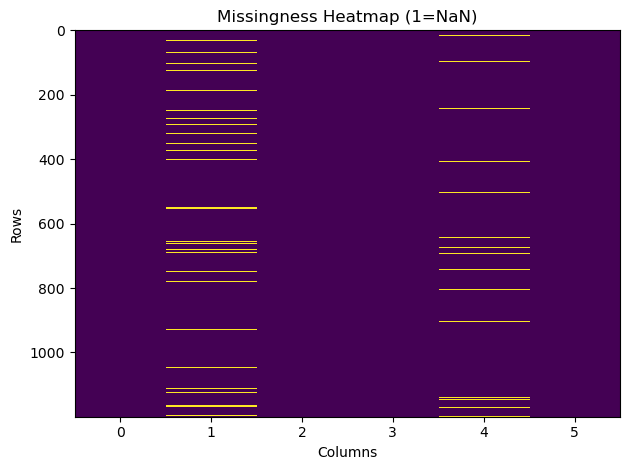

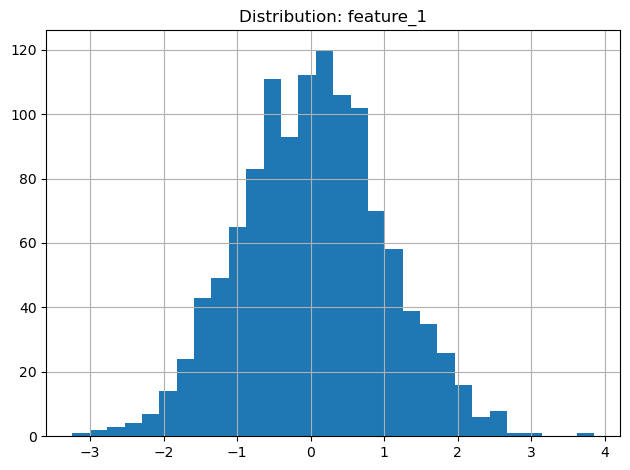

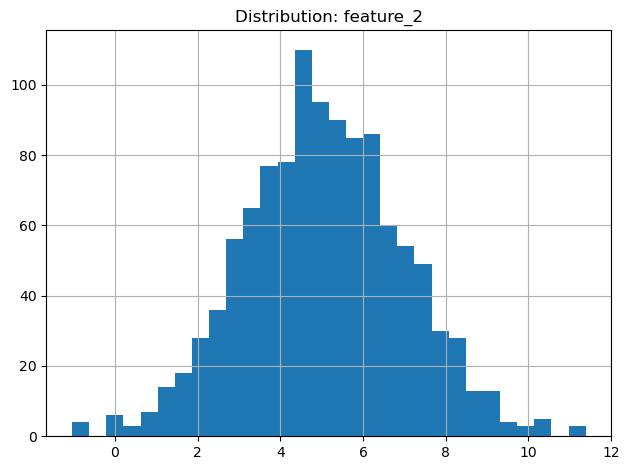

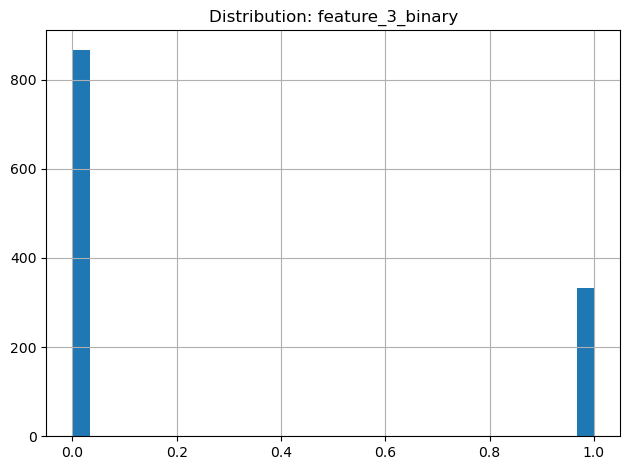

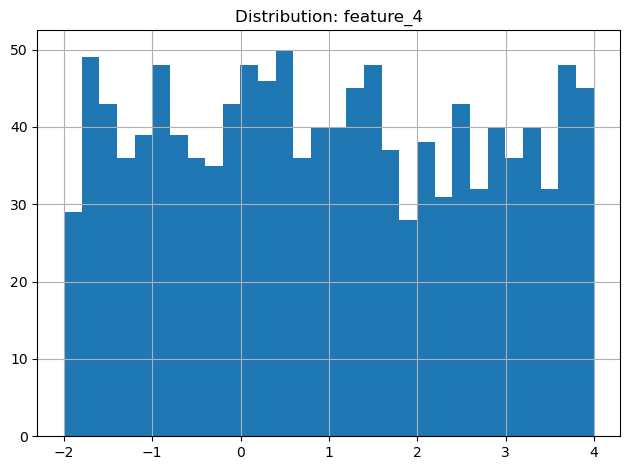

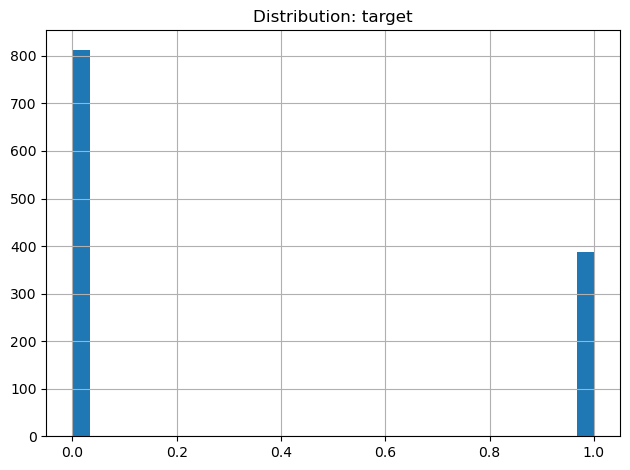

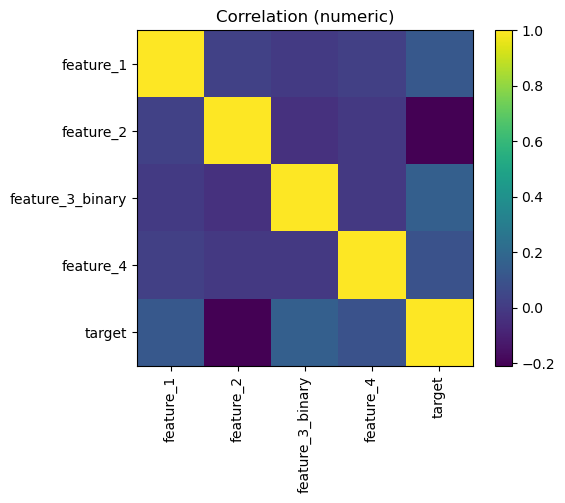

In [3]:
display(df.shape)
display(df.dtypes)
display(df.describe(include='all'))

# Missingness by column
missing = df.isna().mean().sort_values(ascending=False)
display(missing)

# Simple missingness heatmap (binary mask)
plt.figure()
plt.imshow(df.isna(), aspect='auto', interpolation='nearest')
plt.title('Missingness Heatmap (1=NaN)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.savefig(ARTIFACTS / 'missingness_heatmap.png', dpi=150)
plt.show()

# Histograms for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in num_cols:
    plt.figure()
    df[col].hist(bins=30)
    plt.title(f'Distribution: {col}')
    plt.tight_layout()
    plt.savefig(ARTIFACTS / f'hist_{col}.png', dpi=150)
    plt.show()

# Correlation heatmap (numeric only)
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation (numeric)')
plt.colorbar()
plt.tight_layout()
plt.savefig(ARTIFACTS / 'correlation_heatmap.png', dpi=150)
plt.show()


## 3. Cleaning & Preprocessing

- Separate features/target
- Split train/test early to avoid leakage
- Impute missing values
- One-hot encode categoricals
- Standardize numeric features (as needed)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

TARGET = 'target' if 'target' in df.columns else df.columns[-1]
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int) if df[TARGET].dropna().isin([0,1]).all() else df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y if set(pd.unique(y)) <= {0,1} else None,
    random_state=SEED
)

num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

num_features, cat_features


(['feature_1', 'feature_2', 'feature_3_binary', 'feature_4'], ['category'])

## 4. Modeling (Leakage-Aware Pipelines)

Build pipelines that include the preprocessor **inside** the cross-validation to avoid leakage.
Try a few baseline models and evaluate with robust metrics.


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

is_binary = set(pd.unique(y_train.dropna())) <= {0,1}

models = {
    "log_reg": LogisticRegression(max_iter=200, n_jobs=None, random_state=SEED),
    "rf": RandomForestClassifier(n_estimators=300, random_state=SEED),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED) if is_binary else None
scoring = 'roc_auc' if is_binary else 'r2'

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])
    if cv is not None:
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring=scoring)
        results[name] = {
            "cv_scores": scores,
            "mean": np.mean(scores),
            "std": np.std(scores),
        }
    else:
        # Fallback (e.g., regression case) using simple split
        pipe.fit(X_train, y_train)
        pred = pipe.predict(X_test)
        results[name] = {"test_score": float(np.corrcoef(pred, y_test)[0,1])}

pd.DataFrame(results)


,log_reg,rf
cv_scores,"[0.6905707196029777, 0.6787841191066998, 0.639...","[0.6669975186104218, 0.6538461538461539, 0.668..."
mean,0.6866,0.654888
std,0.033589,0.011282


## 5. Final Fit & Evaluation

Choose the best model (by mean CV score), fit on the full training set, and evaluate
on the held-out test set.


In [6]:
# Pick best by mean CV score
best_name = max(
    (k for k in results if 'mean' in results[k]),
    key=lambda k: results[k]['mean']
)
best_model = models[best_name]
final_pipe = Pipeline(steps=[("preprocess", preprocessor), ("model", best_model)])
final_pipe.fit(X_train, y_train)

if is_binary:
    proba = final_pipe.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    print("Test ROC-AUC:", roc_auc_score(y_test, proba))
    print("Test Accuracy:", accuracy_score(y_test, pred))
    print("Test F1:", f1_score(y_test, pred))
else:
    pred = final_pipe.predict(X_test)
    print("Test corr(pred, y):", np.corrcoef(pred, y_test)[0,1])


Test ROC-AUC: 0.6540514700023903
Test Accuracy: 0.6791666666666667
Test F1: 0.2376237623762376


## 6. Uncertainty via Bootstrap Confidence Intervals

Use bootstrap resampling to estimate a confidence interval for the chosen metric.


In [7]:
def bootstrap_ci(metric_fn, y_true, y_score, n_boot=1000, alpha=0.05, seed=SEED):
    rng = np.random.RandomState(seed)
    scores = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        scores.append(metric_fn(y_true[idx], y_score[idx]))
    scores = np.asarray(scores)
    low = np.quantile(scores, alpha/2)
    high = np.quantile(scores, 1 - alpha/2)
    return float(np.mean(scores)), float(low), float(high)

if is_binary:
    proba = final_pipe.predict_proba(X_test)[:,1]
    y_true = y_test.to_numpy()
    auc_mean, auc_lo, auc_hi = bootstrap_ci(roc_auc_score, y_true, proba)
    print(f"Bootstrap ROC-AUC mean={auc_mean:.3f} CI=({auc_lo:.3f}, {auc_hi:.3f})")
else:
    # Example for regression: correlation CI
    pred = final_pipe.predict(X_test)
    def corr_metric(y, yhat):
        return np.corrcoef(y, yhat)[0,1]
    m, lo, hi = bootstrap_ci(corr_metric, y_test.to_numpy(), pred)
    print(f"Bootstrap corr mean={m:.3f} CI=({lo:.3f}, {hi:.3f})")


Bootstrap ROC-AUC mean=0.653 CI=(0.574, 0.728)


## 7. Explainability: Permutation Importance & Partial Dependence

Permutation importance perturbs each feature and measures degradation in the metric.
Partial dependence approximates the average effect of a feature on predictions.


In [8]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

if is_binary:
    scoring_fn = lambda model, X, y: roc_auc_score(y, model.predict_proba(X)[:,1])
else:
    scoring_fn = lambda model, X, y: np.corrcoef(model.predict(X), y)[0,1]

# Permutation importance (on test set)
r = permutation_importance(final_pipe, X_test, y_test, n_repeats=10, random_state=SEED)

# Extract feature names post-transform
final_pipe.fit(X_train, y_train)
pre = final_pipe.named_steps['preprocess']
ohe = pre.named_transformers_['cat'].named_steps['onehot'] if len(pre.transformers_)>1 and 'cat' in dict(pre.transformers_).keys() else None
num_names = num_features
cat_names = ohe.get_feature_names_out(cat_features).tolist() if ohe is not None and len(cat_features)>0 else []
feat_names = num_names + cat_names

importances = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=False)
display(importances.head(15))

plt.figure(figsize=(6,4))
importances.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation Importance (top 15)')
plt.tight_layout()
plt.savefig(ARTIFACTS / 'permutation_importance_top15.png', dpi=150)
plt.show()

# Partial Dependence for top numeric features (if available)
top_numeric = [f for f in importances.index if f in num_names][:2]
if len(top_numeric) > 0:
    fig = plt.figure(figsize=(5,4))
    PartialDependenceDisplay.from_estimator(final_pipe, X_test, features=top_numeric[:2])
    plt.tight_layout()
    plt.savefig(ARTIFACTS / 'partial_dependence.png', dpi=150)
    plt.show()
else:
    print("No numeric features available for partial dependence plots.")


ValueError: dictionary update sequence element #0 has length 3; 2 is required

## 8. Statistical Inference (Hypothesis Testing & Effect Sizes)

Example: compare means between two groups using a t-test, and compute Cohen's d.
Adjust feature/target names to match your dataset.


In [ ]:
from scipy import stats

# Example grouping by a (possibly encoded) categorical feature.
group_feature = 'category' if 'category' in df.columns else None
numeric_feature = 'feature_2' if 'feature_2' in df.columns else None

if group_feature and numeric_feature:
    subset = df[[group_feature, numeric_feature]].dropna()
    groups = subset[group_feature].dropna().unique()
    if len(groups) >= 2:
        g1 = subset[subset[group_feature] == groups[0]][numeric_feature]
        g2 = subset[subset[group_feature] == groups[1]][numeric_feature]
        t, p = stats.ttest_ind(g1, g2, equal_var=False)
        # Cohen's d
        def cohens_d(a, b):
            na, nb = len(a), len(b)
            sa, sb = np.var(a, ddof=1), np.var(b, ddof=1)
            s_pool = (((na-1)*sa + (nb-1)*sb) / (na+nb-2)) ** 0.5
            return (np.mean(a) - np.mean(b)) / s_pool
        d = cohens_d(g1.values, g2.values)
        print(f"t={t:.3f} p={p:.3g} Cohen's d={d:.3f}")
    else:
        print("Need at least two groups for t-test.")
else:
    print("Skipping t-test: adjust 'group_feature' and 'numeric_feature' for your dataset.")


## 9. Save Artifacts & Environment

Export model, figures, metrics, and the Python environment for reproducibility.


In [ ]:
import joblib

# Save final model
MODEL_PATH = ARTIFACTS / 'final_model.joblib'
joblib.dump(final_pipe, MODEL_PATH)
print(f"Saved model to {MODEL_PATH}")

# Save metrics
metrics = {}
if is_binary:
    proba = final_pipe.predict_proba(X_test)[:,1]
    pred = (proba >= 0.5).astype(int)
    metrics = {
        'roc_auc': float(roc_auc_score(y_test, proba)),
        'accuracy': float(accuracy_score(y_test, pred)),
        'f1': float(f1_score(y_test, pred)),
    }
else:
    pred = final_pipe.predict(X_test)
    metrics = {'corr': float(np.corrcoef(pred, y_test)[0,1])}

with open(ARTIFACTS / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics.json")

# Freeze environment
ENV_FILE = ARTIFACTS / 'environment_freeze.txt'
try:
    import subprocess
    out = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'], text=True)
    ENV_FILE.write_text(out)
    print(f"Saved environment to {ENV_FILE}")
except Exception as e:
    print("Could not freeze environment:", e)


## 10. Next Steps

- Consider a formal experiment plan and preregistration.
- Add domain-specific feature engineering and priors.
- Evaluate model fairness and sensitivity analyses.
- Containerize the environment (e.g., Docker) for full portability.
- Promote this notebook to a script + CLI for batch/CI runs.
